This notebook is the first attempt at setting up the physical structure of the disk and the dust distribution within.

Ensure that the radmcd3d and disklab, dsharp_opac, imagecube libraries are installed

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import copy
import pandas as pd

import glob

import disklab
from disklab.natconst import *
from disklab import radmc3d
from disklab import DiskRadialModel

In [ ]:
# decide which optical constants to use

opac_name = 'DSHARP' # choices: DSHARP, Draine

# define wave length and particle size grids for which the opacities would be calculated and stored. Change the values based on the required granularity and the dust species in the model

lam_opac   = np.logspace(-5, 1, 200)
a_opac     = np.logspace(-5, -1, 100)
#a_opac = np.array([5.e-5,1.e-1])

In [3]:
import dsharp_opac as opacity

# define optical constants and material density

if opac_name == 'Draine':
    fname = 'dustkappa_draine2003_astrosilicates'
    diel_const = opacity.diel_draine2003('astrosilicates')
    rho_s = 3.5
elif opac_name == 'DSHARP':
    fname = 'dustkappa_default'
    diel_const, rho_s = opacity.get_dsharp_mix()
    diel_const.extrapol

# call the Mie calculation & store the opacity in a npz file

opac_dict = opacity.get_opacities(a_opac, lam_opac, rho_s=rho_s, diel_const=diel_const, extrapolate_large_grains=True)
opacity.write_disklab_opacity(fname, opac_dict)

Please cite Warren & Brandt (2008) when using these optical constants
Please cite Draine 2003 when using these optical constants
Reading opacities from troilitek
Please cite Henning & Stognienko (1996) when using these optical constants
Reading opacities from organicsk
Please cite Henning & Stognienko (1996) when using these optical constants
| material                            | volume fractions | mass fractions |
|-------------------------------------|------------------|----------------|
| Water Ice (Warren & Brandt 2008)    | 0.3642           | 0.2            |
| Astronomical Silicates (Draine 2003)| 0.167            | 0.329          |
| Troilite (Henning)                  | 0.02578          | 0.07434        |
| Organics (Henning)                  | 0.443            | 0.3966         |
Mie ... Done!


In [13]:
# The initial physical parameters of the disk need to be input here. Not all of the parameters mentioned here are necessary

# Mass, t and luminosity from Avenhaus 2018 for IMLup
mstar      = 0.7 * MS
lstar      = 1.56 * LS
tstar      = 4266.00
mdust      = 121 * Mea * 5
d2g        = 0.01
mdisk      = mdust / d2g
flang      = 0.05            #??
zrmax      = 1.0             #??
nr         = 100
rin        = 0.1 * au
r_c        = 100 * au        #??
rout       = 400 * au        #400au from avenhaus paper  #DSHARP Huang 2018 says 290 au
alpha      = 1e-3


opac_params = ['dustcomponents', {'method': 'simplemixing'}]

In [38]:
# initializing a 1d disk class from disklab
d = disklab.DiskRadialModel(mstar=mstar, lstar=lstar, tstar=tstar, mdisk=mdisk, nr=nr, alpha=alpha, rin=rin, rout=rout)

# setting radial density. The arguments are the normalisation and exponent of simplified LBP model. Can be changed so that final output matches the observation better
d.make_disk_from_simplified_lbp(2.63011968, 3*r_c, 0.87152782)


# add N dust species. Change N based on model. Try to keeo agrains same as a_opac from above

ngrains = 100
#agrains = np.array([1.e-,1.e-1])
agrains = np.logspace(-4, -1, ngrains)

# Setting the relative density across different dust species according to MRN
size_distri = agrains**0.5
size_distri /= size_distri.sum()

# define dust colors
cols = [f'{0.2 + 0.6 * idust / (ngrains - 1)}' for idust in range(ngrains)][::-1]



In [39]:
# a_max is a matrix used to represent max size of the dust at a radius r. The values in this matrix will be updated later in subsequent steps
a_max = np.tile(agrains,(len(d.r),1))

In [40]:
size_distri = a_max # just for shape

In [36]:
# Run this cell for a sharp cutoff of large grains in a two grain model (large dust represented by index [1] in the matrix a_max. The cutoff is at 300 au
for i in range(0,len(d.r)):
    if d.r[i]/AU > 300:
        a_max[i][1]  = 1e-50
    size_distri[i] = a_max[i]**0.5
    size_distri[i] /= size_distri[i].sum()


In [41]:
# Run this cell in case of continous distribution of dust species and for reducing a_max as a function of r. The steepness of reduction can be changed (currently -5/4) and also the point from where the reduction starts taking place (currently 0.5 units)
for i in range(0,len(d.r)):
    a_max[i][agrains > (d.r[i]/AU)**(-5/4) * 0.5] = 1e-50
    size_distri[i] = a_max[i]**0.5
    size_distri[i] /= size_distri[i].sum()

In [42]:
# adding the dust grains to the radial disk object
for eps, agrain in zip(np.transpose(size_distri),  agrains):
    d.add_dust(agrain=agrain, xigrain=rho_s, dtg=d2g * eps)

In [43]:
def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy."""
    return [float('nan') if x<1e-20 else x for x in values]

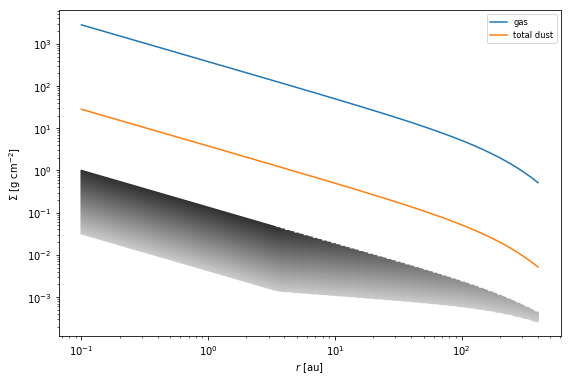

In [44]:
# The next few cells plot the dust distribution

ngrains = len(d.dust)
sig_d = np.sum([dust.sigma for dust in d.dust], 0)

f, ax = plt.subplots(figsize=(9, 6))
ax.loglog(d.r / AU, d.sigma, label='gas')
ax.loglog(d.r / AU, sig_d, label='total dust')

for col, dust in zip(cols, d.dust):
    ax.loglog(d.r / AU, zero_to_nan(dust.sigma), c=col)
#ax.loglog(d.r / AU, d.dust[1].sigma, c=col, label=f'$a = {dust.grain.agrain:.2g}$')
ax.legend(fontsize='small')
ax.set_xlabel('$r$ [au]')
ax.set_ylabel('$\Sigma$ [g cm$^{-2}$]');
#ax.set_ylim(1e-4, 1e5);
#ax.set_xscale('linear')
plt.savefig('radial_density_decreasin_amax.png', dpi=300)

In [45]:
total_dust_sigma = d.dust[0].sigma
for dust in d.dust[1:len(d.dust)]:
    total_dust_sigma = np.vstack((total_dust_sigma, dust.sigma))

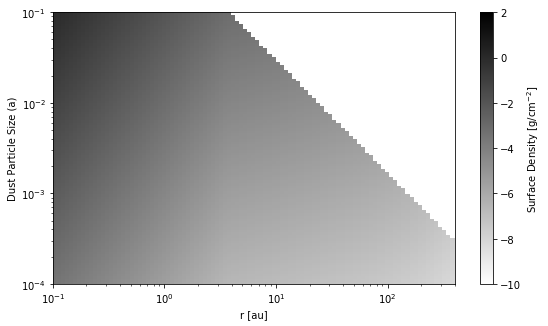

In [49]:
fig, ax = plt.subplots(figsize=(9, 5))
psm = ax.pcolormesh(d.r / AU, (agrains[0:len(agrains)]),np.log(total_dust_sigma), rasterized=True, cmap='binary', vmin=-10, vmax=2)
#psm = ax.pcolor(np.transpose(density_weights), rasterized=True, cmap='binary')
cbar = fig.colorbar(psm, ax = ax)
cbar.set_label('Surface Density [g/cm$^{-2}$]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('r [au]')
ax.set_ylabel('Dust Particle Size (a)')
#plt.show()
plt.savefig('dust_density.png', dpi=300)

In [24]:
# loading the opacity from the previously calculated opacity table

for dust in d.dust:
    #dust.grain.load_standard_opacity('draine2003', 'astrosilicates', verbose=True)
    dust.grain.read_opacity(fname + '.npz')
    
# compute the mean opacities

d.meanopacitymodel = opac_params
d.compute_mean_opacity()

In [25]:
# Converting the radial disk object to a 2d disk object
disk2d = disklab.Disk2D(disk=d, zrmax=zrmax, meanopacitymodel=d.meanopacitymodel, nz=200)

Plot the vertical structure

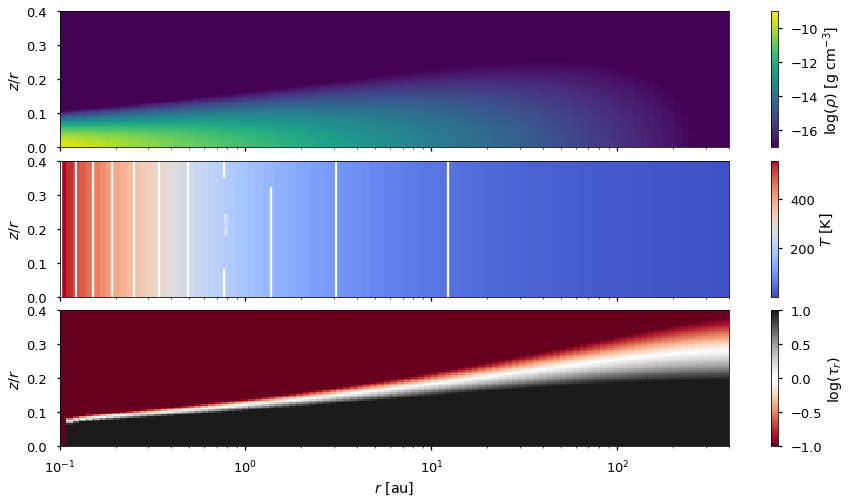

In [74]:
X0,Z0,rho0,T0,tau0,f = disklab.radmc3d.plot_vert_structure(disk2d)
#plt.savefig('vertstruct1.pdf')

In [75]:
# The vertical structure of the disk will now be set up here using a full 2d radiative diffusion. Further information can be found in the snippets from the disklab library and my thesis

for vert in disk2d.verts:
    vert.compute_rhogas_hydrostatic()

In [76]:
for vert in disk2d.verts:
    vert.compute_mean_opacity()
    vert.iterate_vertical_structure()
    #vert.irradiate_with_flaring_index()
    #vert.compute_viscous_heating()
    #vert.solve_vert_rad_diffusion()
    #vert.compute_temperature_from_radiation()

In [77]:
#%%time
tgas_del   = np.array([])
rhogas_del = np.array([])
maxiter    = 5

vmax=-6

for iter in range(maxiter):
    tgas_del_iter   = 0
    rhogas_del_iter = 0
    disk2d_previous = copy.deepcopy(disk2d)
    for vert in disk2d.verts:
        vert.compute_mean_opacity()
    disk2d.radial_raytrace()
    #disk2d.setup_spherical_coordinate_system()
    disk2d.solve_2d_rad_diffusion(thist=True, simplecoordtrans=True)
    #for slice in range(len(disk2d.verts)):
    #    tgas_del_vert   = np.sum((disk2d_previous.verts[slice].tgas - disk2d.verts[slice].tgas)**2)
    #    tgas_del_iter   = tgas_del_iter + tgas_del_vert
    #for vert_previous, vert in zip(disk2d_previous.verts, disk2d.verts):
    #    vert.tgas = 0.6 * vert_previous.tgas + 0.4 * vert.tgas
    for vert in disk2d.verts:
        vert_previous = copy.deepcopy(vert)
        vert.compute_rhogas_hydrostatic()
        rhogas_del_vert = np.sum((vert_previous.rhogas - vert.rhogas)**2)
        rhogas_del_iter = rhogas_del_iter + rhogas_del_vert
        for dust in vert.dust:
            dust_previous = copy.deepcopy(dust)
            dust.compute_settling_mixing_equilibrium()
            dust.rho = (dust_previous.rho + 0.4 * dust.rho) * sum(dust.rho * vert.dz) / sum((dust_previous.rho + 0.4*dust.rho) * vert.dz)
    #    vert.tgas = (vert.tgas**4 + 10**4)**(1/4)
    #tgas_del   = np.append(tgas_del, tgas_del_iter)
    #rhogas_del = np.append(rhogas_del, rhogas_del_iter)
        
    rho_t = np.array([vert.rhogas for vert in disk2d.verts])
    Z = np.array([vert.z for vert in disk2d.verts])
    X = disk2d.r[:, None] * np.ones_like(Z)
    
    '''
    fig, ax = plt.subplots(figsize=(15, 8))
    #ax = fig.add_subplot(111)
    cmesh = ax.pcolormesh(X / au, Z / X, np.log10(rho_t + 1e-100),vmin=vmax - 8, vmax=vmax)  # gist_heat_r
    cbar = fig.colorbar(cmesh, ax = ax)
    cbar.set_label(r'$\log(\rho)$ [g cm$^{-3}$]')
    ax.set_xscale('log')
    ax.set_xlabel('r [au]')
    ax.set_ylabel('$z/r$')
    ax.set_ylim(0,0.4)
    plt.savefig(str(iter)+'.png', dpi=300)
    '''

  Nr of iter linear solver: 3469. Flux limiter iteration:  0. Error = 5.5368641285321205
  Nr of iter linear solver: 2271. Flux limiter iteration:  1. Error = 0.727076745302262
  Nr of iter linear solver: 2273. Flux limiter iteration:  2. Error = 0.48039037968580933
  Nr of iter linear solver: 2215. Flux limiter iteration:  3. Error = 0.19698223678614557
  Nr of iter linear solver: 2214. Flux limiter iteration:  4. Error = 0.04934957536136775
  Nr of iter linear solver: 2191. Flux limiter iteration:  5. Error = 0.026271603544710143
  Nr of iter linear solver: 2160. Flux limiter iteration:  6. Error = 0.01750286532795209
  Nr of iter linear solver: 2107. Flux limiter iteration:  7. Error = 0.011790283013103475
  Nr of iter linear solver: 2063. Flux limiter iteration:  8. Error = 0.010783739220996291
  Nr of iter linear solver: 2134. Flux limiter iteration:  9. Error = 0.00928073342099478
  Nr of iter linear solver: 2075. Flux limiter iteration: 10. Error = 0.0078576049932505
  Nr of ite

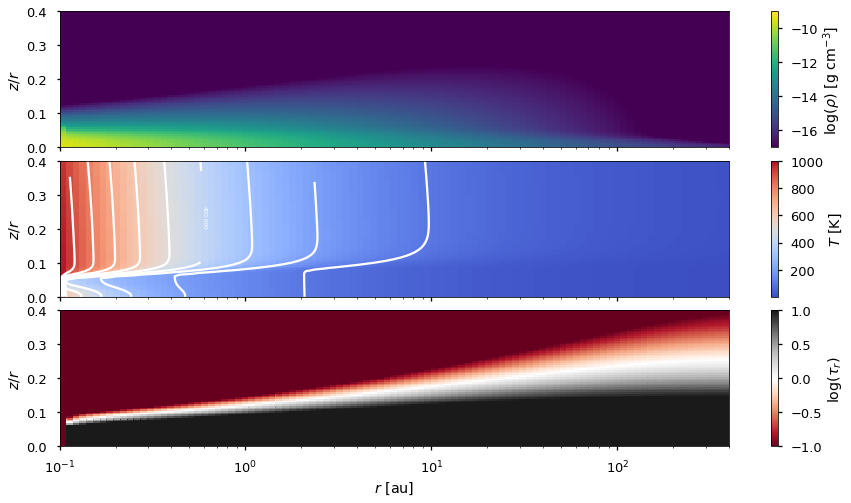

In [78]:
X0,Z0,rho0,T0,tau0,f = disklab.radmc3d.plot_vert_structure(disk2d)
#plt.savefig('vertstruct1.pdf')

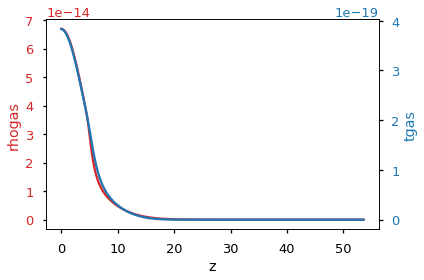

In [80]:
# Vertical density and temperature profile at a certain radius

x = 75

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('z')
ax1.set_ylabel('rhogas', color=color)
ax1.plot(disk2d.verts[x].z/au, disk2d.verts[x].rhogas, color=color)
#ax1.plot(disk2d.verts[x].z/au, disk2d.verts[x].dust[0].rho, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('tgas', color=color)  # we already handled the x-label with ax1
#ax2.plot(disk2d.verts[x].z/au, disk2d.verts[x].tgas, color=color)
ax2.plot(disk2d.verts[x].z/au, disk2d.verts[x].dust[0].rho, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## RADMC3D Setup

So far we were working in cylindrical coordinates, now we need to create spherical ones and interpolate onto those

In [32]:
#disk2d.zdivr = disk2d.verts[-1].z / d.r[-1]

In [81]:
rmcd = disklab.radmc3d.get_radmc3d_arrays(disk2d, showplots=False)

Assign the radmc3d data

In [82]:
nphi   = rmcd['nphi']
ri     = rmcd['ri']
thetai = rmcd['thetai']
phii   = rmcd['phii']
nr     = rmcd['nr']
nth    = rmcd['nth']
nphi   = rmcd['nphi']
rho    = rmcd['rho']

Define the wavelength grid for the radiative transfer

In [83]:
nlam = 200
lam = np.logspace(-5,1,nlam)
lam_mic = lam * 1e4

Write the `RADMC3D` input

In [84]:
!rm dustkappa_*.inp

In [85]:
radmc3d.write_stars_input(d,lam_mic)
radmc3d.write_grid(ri, thetai, phii, mirror=False)
radmc3d.write_dust_density(rho, mirror=False)
radmc3d.write_wavelength_micron(lam_mic)
radmc3d.write_opacity(disk2d)
radmc3d.write_radmc3d_input({'scattering_mode': 5, 'scattering_mode_max': 5, 'nphot': 10000000})

In [86]:
%%time
# radiative transfer calculation of the temperature
radmc3d.radmc3d('mctherm setthreads 4')

>>>   
>>>    ================================================================
>>>         WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER
>>>   
>>>           This is the 3-D reincarnation of the 2-D RADMC code
>>>                   (c) 2010/2015 Cornelis Dullemond
>>>   
>>>    ************* NOTE: THIS IS STILL A BETA VERSION ***************
>>>    ****** Some modes/capabilities are not yet ready/mature ********
>>>   
>>>          Please feel free to ask questions. Also please report
>>>           bugs and/or suspicious behavior without hestitation.
>>>         The reliability of this code depends on your vigilance!
>>>   
>>>      To keep up-to-date with bug-alarms and bugfixes, register to
>>>         the RADMC-3D mailing list by sending an email to me:
>>>                       dullemond@uni-heidelberg.de
>>>   
>>>                 Please visit the RADMC-3D home page at
>>>     http://www.ita.uni-heidelberg.de/~dullemond/software/radmc-3d/
>>>    =========================

In [65]:
# Next couple of cells plot the temperature profile comparison by radiative diffusion and MC therm

grid = radmc3d.read_amr_grid()
data = radmc3d.read_data(dtemp=True, ddens=True)

nspec = len(glob.glob('dustkappa_*.inp'))

# Interpolate temperature on same grid

X_c = grid.r[:, None] * np.cos(np.pi / 2 - grid.thetai[:0:-1])[None, :]
Y_c = grid.r[:, None] * np.sin(np.pi / 2 - grid.thetai[:0:-1])[None, :]

points = np.array(list(zip(np.log10(X_c).flatten(),Y_c.flatten())))
values = np.log10(data.rho[:,::-1,0,0].flatten())
newpoints = np.array(list(zip(np.log10(X0.flatten()),Z0.flatten())))

rho_sph = 10.**griddata(points,values,newpoints,fill_value=-100, rescale=True).reshape(*X0.shape)
T2 = griddata(points,data.temp[:,::-1,0,0].flatten(),newpoints, rescale=True).reshape(*X0.shape)

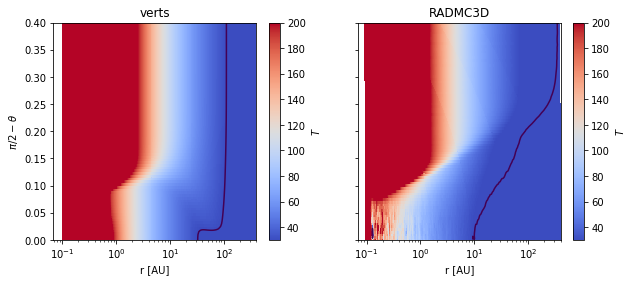

In [69]:
f,axs = plt.subplots(1,2,sharex=True,sharey=True,figsize=(10,4))

vmin = 30
vmax = 200

c2 = axs[0].pcolormesh(X0/au, Z0/X0, T0,cmap='coolwarm',vmin=vmin,vmax=vmax)
cc = axs[0].contour(X0/au, Z0/X0, T0, [30])
cb = plt.colorbar(c2,ax=axs[0])
cb.set_label(r'$T$')
axs[0].set_title('verts')

c1 = axs[1].pcolormesh(X_c/au, Y_c/X_c, data.temp[:,::-1,0,0],cmap='coolwarm',vmin=vmin,vmax=vmax)
cc = axs[1].contour(X_c/au, Y_c/X_c, data.temp[:,::-1,0,1], [30])
cb = plt.colorbar(c1,ax=axs[1])
cb.set_label(r'$T$')
axs[1].set_title('RADMC3D')


for ax in axs:
    ax.set_xlabel('r [AU]')
    ax.set_xscale('log')
    ax.set_ylim(0,0.4)
axs[0].set_ylabel(r'$\pi/2-\theta$');

radiative transfer image calculation

In [87]:
%%time
lam_obs = 0.125
rd = 300 * au
radmc3d.radmc3d(f'image incl 47.5 posang -144.4 npix 500 lambda {lam_obs * 1e4} sizeau {4*rd/au} secondorder')

>>>   
>>>    ================================================================
>>>         WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER
>>>   
>>>           This is the 3-D reincarnation of the 2-D RADMC code
>>>                   (c) 2010/2015 Cornelis Dullemond
>>>   
>>>    ************* NOTE: THIS IS STILL A BETA VERSION ***************
>>>    ****** Some modes/capabilities are not yet ready/mature ********
>>>   
>>>          Please feel free to ask questions. Also please report
>>>           bugs and/or suspicious behavior without hestitation.
>>>         The reliability of this code depends on your vigilance!
>>>   
>>>      To keep up-to-date with bug-alarms and bugfixes, register to
>>>         the RADMC-3D mailing list by sending an email to me:
>>>                       dullemond@uni-heidelberg.de
>>>   
>>>                 Please visit the RADMC-3D home page at
>>>     http://www.ita.uni-heidelberg.de/~dullemond/software/radmc-3d/
>>>    =========================

# Reading RADMC-3D

Read the image data

In [75]:
# using the radmc3d library to output a fits file. Ignore this cell if only want to display image on the screen
from radmc3dPy import *
#data = analyze.readData(dtemp=True, binary = False)
im = image.readImage()
im.writeFits('myimage.fits', dpc=158.)

Reading image.out
myimage.fits already exists


Do you want to overwrite it (yes/no)? yes


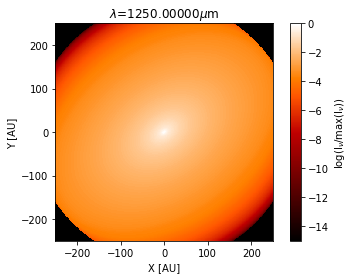

{'implot': <matplotlib.image.AxesImage at 0x7f77709c6198>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x7f776ba0f978>}

In [43]:
image.plotImage(im, au=True, log=True, maxlog=15,cmap=plt.cm.gist_heat)

In [88]:
# Plotting image
im = radmc3d.read_image()

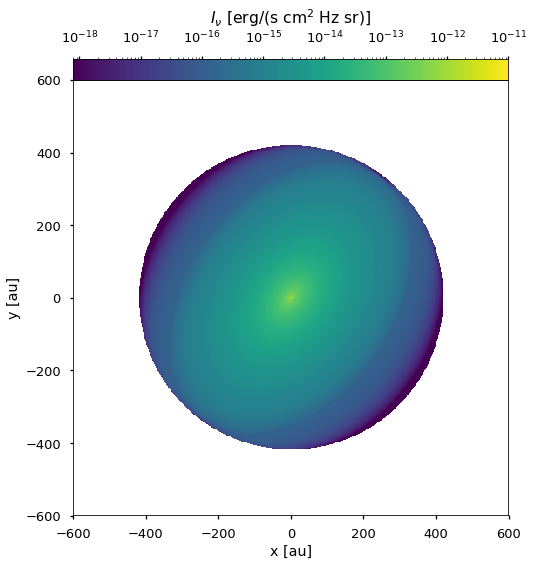

In [89]:
from matplotlib.colors import LogNorm

#vmin_arr = [1e-17, 4.7e-15]

f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect(1)
vmax = 0.5 * im.image.max()
vmin = 5e-16
cc   = ax.pcolormesh(im.x / au, im.y / au, im.image, norm=LogNorm(), vmax=1e-11 ,vmin=8e-19, rasterized=True)

pos = ax.get_position()
cb = plt.colorbar(cc, orientation='horizontal')
cb.ax.set_position([pos.x0, pos.y1, pos.width, 0.05 * pos.height])
ax.set_position([pos.x0, pos.y0,pos.width, pos.height])
cb.ax.xaxis.tick_top()
cb.ax.set_title(r'$I_\nu$ [erg/(s cm$^2$ Hz sr)]')
ax.set_xlabel('x [au]')
ax.set_ylabel('y [au]')
f.savefig('image_1250micron.png')

In [91]:
# The next couple of cells plot the radial intensity profile along the semi major axis

radial_profile = []
radial = []
for x, y in zip(range(0,251,1),range(249,500,1)):
    radial_profile.append(im.image[y][int(round(249+x*np.tan(0.6213372)))])
    radial.append(np.sqrt((im.x[int(round(249+x*np.tan(0.6213372)))]/au)**2 + (im.y[y]/au)**2) )

Text(0, 0.5, '$I_\\nu$ [erg/(s cm$^2$ Hz sr)]')

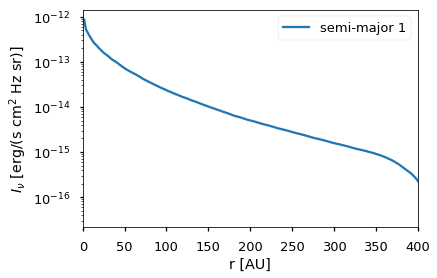

In [92]:
plt.plot(np.asarray(radial),np.asarray(radial_profile), label='semi-major 1')
plt.yscale('log')
#plt.xscale('log')

plt.xlabel('r [AU]')
plt.xlim(left=0, right=400)
#plt.ylim(bottom=0)
plt.legend()
plt.ylabel(r'$I_\nu$ [erg/(s cm$^2$ Hz sr)]')
#plt.savefig('radial_profile.png', dpi=300)

The obtained radial intensity profile will now be to the blackbody emmission of the dust species

In [93]:
import astropy.units as u
import astropy.constants as c

def planck_B_nu(freq, T):
    """
    Calculates the value of the Planck-Spectrum
    B(nu,T) of a given frequency nu and temperature T

    Arguments
    ---------
    nu : float or array
        frequency in 1/s or with astropy.units

    T: float
        temperature in K or in astropy.units

    Returns:
    --------
    B : float
        value of the Planck-Spectrum at frequency nu and temperature T
        units are using astropy.units if the input values use those, otherwise
        cgs units: erg/(s*sr*cm**2*Hz)

    """
    if isinstance(T, u.quantity.Quantity):
        use_units = True
    else:
        T = T * u.K
        use_units = False

    if not isinstance(freq, u.quantity.Quantity):
        freq *= u.Hz

    T = np.array(T.value, ndmin=1) * T.unit
    freq = np.array(freq.value, ndmin=1) * freq.unit

    f_ov_T = freq[np.newaxis, :] / T[:, np.newaxis]
    mx = np.floor(np.log(np.finfo(f_ov_T.ravel()[0].value).max))
    exp = np.minimum(f_ov_T * c.h / c.k_B, mx)
    exp = np.maximum(exp, -mx)

    output = 2 * c.h * freq**3 / c.c**2 / (np.exp(exp) - 1.0) / u.sr

    cgsunit = 'erg/(s*sr*cm**2*Hz)'
    if use_units:
        return output.to(cgsunit).squeeze()
    else:
        return output.to(cgsunit).value.squeeze()


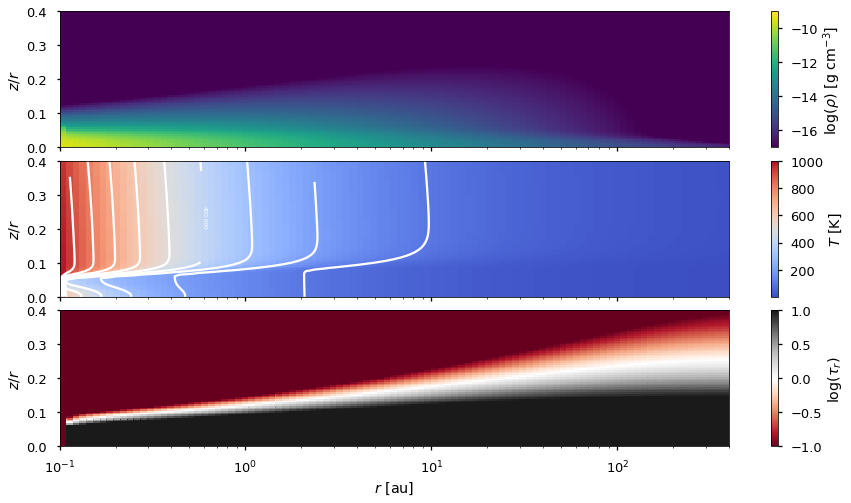

In [94]:
X0,Z0,rho0,T0,tau0,f = disklab.radmc3d.plot_vert_structure(disk2d)

In [95]:
B = planck_B_nu(c.c/(1.25*u.mm),T0*u.K)

In [96]:
I_v = (B*(1-np.exp(-tau0))).cgs.value

In [97]:
I_r = np.array([np.sum(x) for x in I_v])

In [98]:
grid = radmc3d.read_amr_grid()
data = radmc3d.read_data(dtemp=True, ddens=True)

X_c = grid.r[:, None] * np.cos(np.pi / 2 - grid.thetai[:0:-1])[None, :]
Y_c = grid.r[:, None] * np.sin(np.pi / 2 - grid.thetai[:0:-1])[None, :]

In [99]:
opacity_data = np.load('dustkappa_default.npz')

In [100]:
k_total = (opacity_data['k_abs'] + opacity_data['k_sca'])

In [101]:
sum_sig_kap = 0
for i in range(len(d.dust)):
    sum_sig_kap = sum_sig_kap + (d.dust[i].sigma * k_total[i][136])

In [102]:
I_r2 = (planck_B_nu(c.c/(1.25*u.mm),T0[:,0]*u.K)*(1-np.exp(-sum_sig_kap))).cgs.value
I_r3 = np.cos(0.8290314)*(planck_B_nu(c.c/(1.25*u.mm),T0[:,0]*u.K)*(1-np.exp(-sum_sig_kap*(1/np.cos(0.8290314))))).cgs.value

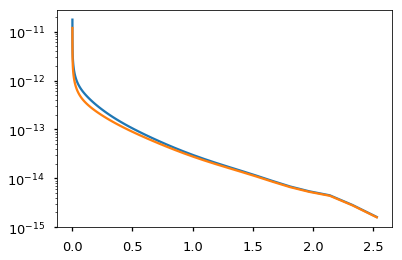

In [103]:
plt.plot(X0[:,0]/158/au ,I_r2)
plt.plot(X0[:,0]/158/au ,I_r3)
plt.yscale('log')

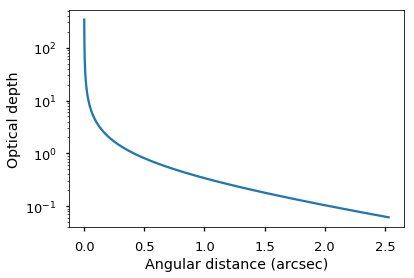

In [104]:
plt.plot(X0[:,0]/au/158, sum_sig_kap)
plt.yscale('log')
plt.xlabel('Angular distance (arcsec)')
plt.ylabel('Optical depth')
plt.savefig('OpticalDepth.png', dpi=300)

# Try out `imagecube`

Imagecube azimuthally averages intensity to calculate the radial intensity

Comparison between the intensity obtained along the semi major axis and the azimutally averaged can be seen here

In [105]:
import numpy as np  
import matplotlib.pyplot as plt  
import astropy.constants as c  
import astropy.units as u  
from astropy.io import fits

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from astropy.visualization import AsinhStretch, ImageNormalize

%matplotlib inline

import dsharp_helper as dh
from imgcube import imagecube

In [106]:
plt.style.use('seaborn-talk')

Get the data file and disk properties from `dsharp_helper`

In [107]:
disk = 'IMLup'
fname = dh.get_datafile(disk)
PA = dh.sources.loc[disk]['PA']
inc = dh.sources.loc[disk]['inc']
distance = dh.sources.loc[disk]['distance [pc]']

Load the image cube

In [108]:
data = imagecube(fname, clip=2.5)

### Radial profile fitting

In [109]:
x, y, dy = data.radial_profile(inc=inc, PA=PA)

### Unit conversion

The data is in Jy/beam. We convert it to cgs units

In [110]:
sr_per_beam = np.pi * data.header['bmaj'] * data.header['bmin'] / (4 * np.log(2)) * (1*u.degree**2).to('sr').value
profile = (y * u.Jy / sr_per_beam).cgs.value
profile_err = (dy * u.Jy / sr_per_beam).cgs.value

### Overplot the profiles

Getting a fixed radial grid for the DSHARP data release

In [111]:
ds_data = dh.get_profile(disk)
r_as2 = ds_data['data'][:, 0]/distance
I_ds = ds_data['I_nu']

In [ ]:
f, ax = plt.subplots(figsize=(15, 8))
#f, ax = dh.plot_profile(disk)
#ax.get_lines()[0].set_label('DSHARP')
ax.loglog(r_as2, I_ds, label='DSHARP-fixed')
ax.loglog(x, profile, 'k:', label='result from imgcube')
ax.loglog(np.asarray(radial)/158,np.asarray(radial_profile), label='semi-major axis')
ax.loglog(X0[:,0]/158/au,I_r3, label='Theoretical')

ax.fill_between(x, profile - profile_err, y2=profile + profile_err, facecolor='0.6')
ax.set_xscale('linear')
ax.set_xlim(0, 2.5)
ax.set_ylabel('Intensity')
ax.set_xlabel('r [arcsec]')
#ax.set_ylim(1e-16, 3e-12)
ax.legend()
#plt.savefig('radial_profile.png', dpi=300);

In [ ]:
f, ax = plt.subplots(figsize=(15, 8))
#f, ax = dh.plot_profile(disk)
#ax.get_lines()[0].set_label('DSHARP')
ax.loglog(r_as2, I_ds, label='DSHARP-fixed')
ax.loglog(x, profile, 'k:', label='result from imgcube')
ax.loglog(np.asarray(radial)/158,np.asarray(radial_profile)*1.5, label='semi-major axis')
#ax.loglog(X0[:,0]/158/au,I_r3, label='Theoretical')

ax.fill_between(x, profile - profile_err, y2=profile + profile_err, facecolor='0.6')
ax.set_xscale('linear')
ax.set_xlim(0, 2.5)
ax.set_ylabel('Intensity')
ax.set_xlabel('r [arcsec]')
#ax.set_ylim(1e-16, 3e-12)
ax.legend()
#plt.savefig('radial_profile.png', dpi=300);

SED

In [72]:
# The SED is calculated and compared

radmc3d.radmc3d('spectrum incl 47.5 posang -144.4 lambdarange 0.1 10000. nlam 200')

>>>   
>>>    ================================================================
>>>         WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER
>>>   
>>>           This is the 3-D reincarnation of the 2-D RADMC code
>>>                   (c) 2010/2015 Cornelis Dullemond
>>>   
>>>    ************* NOTE: THIS IS STILL A BETA VERSION ***************
>>>    ****** Some modes/capabilities are not yet ready/mature ********
>>>   
>>>          Please feel free to ask questions. Also please report
>>>           bugs and/or suspicious behavior without hestitation.
>>>         The reliability of this code depends on your vigilance!
>>>   
>>>      To keep up-to-date with bug-alarms and bugfixes, register to
>>>         the RADMC-3D mailing list by sending an email to me:
>>>                       dullemond@uni-heidelberg.de
>>>   
>>>                 Please visit the RADMC-3D home page at
>>>     http://www.ita.uni-heidelberg.de/~dullemond/software/radmc-3d/
>>>    =========================

In [73]:
SEDobs = pd.read_csv('observedsed.txt',delimiter=',')

In [74]:
SEDobs['total_error'] = (SEDobs['fluxerror1']**2 + (SEDobs[' flux']*SEDobs['fluxerror2']/100)**2)**0.5

In [75]:
SED = pd.read_csv('spectrum.out', delimiter='   ',skiprows = 2, names=['lam','flux'] )

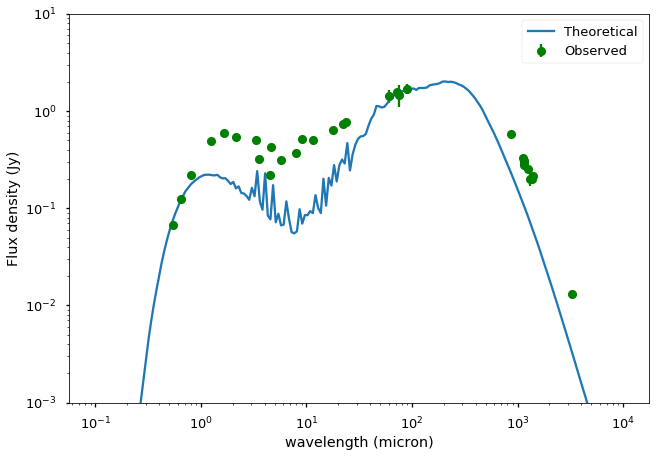

In [81]:
fig, ax1 = plt.subplots()
#ax2 = ax1.twinx()

ax1.plot(SED['lam'],SED['flux'] * 1e23 / 158**2 , label='Theoretical')
#ax1.plot(SEDobs['lambda'],SEDobs[' flux'], 'go', label = 'Observed')
ax1.errorbar(SEDobs['lambda'],SEDobs[' flux'], yerr=SEDobs['total_error'], fmt='o',color='g', label='Observed')
##ax1.plot(lambda_teff,flux_teff * 1e23 / 158**2, label='T_eff corrected')
ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_xlabel('wavelength (micron)')
ax1.set_ylabel('Flux density (Jy)')#'(erg/cm$^2$(?))')
#ax1.set_xlim(500,3500)
ax1.set_ylim(1e-3,1e1)
ax1.legend()
#fig.savefig('SED.png', dpi=300)